In [64]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from layers import FreeSpacePropagation
import time

plt.rcParams["font.size"]=18

In [113]:
class AngularSpectrum(tf.keras.layers.Layer):
    def __init__(self,output_dim, k, z=0, d=1e-6, normalization=None):
        super(AngularSpectrum, self).__init__()
        self.output_dim = output_dim
        self.k = k
        self.z = z
        self.d = d
        self.normalization = normalization

    def build(self, input_dim):
        self.input_dim = input_dim
        self.pad_upper = math.ceil(self.input_dim[-2]/2)
        self.pad_left = math.ceil(self.input_dim[-1]/2)

        kx = np.fft.fftfreq(int(input_dim[-1] + self.pad_left * 2), d=self.d) * 2 * np.pi
        ky = np.fft.fftfreq(int(input_dim[-2] + self.pad_upper * 2), d=self.d) * 2 * np.pi
        KX, KY = np.meshgrid(kx, ky)
        kz = np.where(KX**2 + KY**2 >= self.k, tf.sqrt(self.k**2 - KX**2 - KY**2), 0).astype('float64')
        h =2*np.pi / (1.0j * self.k * self.z)  * np.exp(1.0j * kz * self.z)
        self.res = tf.cast(tf.complex(h.real, h.imag), dtype=tf.complex64)

    @tf.function
    def propagation(self, cximages):
        padding = [[0,0],[self.pad_upper, self.pad_upper],[self.pad_left, self.pad_left]]
        images_pad = tf.pad(cximages, paddings=padding)
        images_pad_fft = tf.signal.fft2d(images_pad)
        u_images_pad = tf.signal.ifft2d(images_pad_fft * self.res)
        u_images = tf.keras.layers.Lambda(lambda x:x[:, self.pad_upper:self.pad_upper+self.input_dim[-2], self.pad_left:self.pad_left+self.input_dim[-1]])(u_images_pad)
        return u_images

    def call(self, x):
        rcp_x = tf.keras.layers.Lambda(lambda x:x[:,0,0,:,:])(x)
        rcp_y = tf.keras.layers.Lambda(lambda x:x[:,0,1,:,:])(x)
        lcp_x = tf.keras.layers.Lambda(lambda x:x[:,1,0,:,:])(x)
        lcp_y = tf.keras.layers.Lambda(lambda x:x[:,1,1,:,:])(x)

        u_rcp_x = self.propagation(rcp_x)
        u_rcp_y = self.propagation(rcp_y)
        u_lcp_x = self.propagation(lcp_x)
        u_lcp_y = self.propagation(lcp_y)

        rcp = tf.stack([u_rcp_x, u_rcp_y], axis=1)
        lcp = tf.stack([u_lcp_x, u_lcp_y], axis=1)

        rl = tf.stack([rcp, lcp], axis=1)

        if self.normalization=='max':
            rl = rl / tf.reduce_max(rl)

        return rl

In [18]:
class CxTest(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(CxTest, self).__init__()
        self.output_dim = output_dim

    def call(self, inputs, **kwargs):

        return inputs**2

In [19]:
class ImageResize(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(ImageResize, self).__init__()
        self.output_dim = output_dim

    def call(self, x):
        x_expnad = tf.image.resize(tf.expand_dims(x, -1), self.output_dim)
        x_expnad = tf.keras.layers.Lambda(lambda x: x[:, :, :, 0])(x_expnad)
        return x_expnad

In [66]:
class InputToCx(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(InputToCx, self).__init__()
        self.output_dim = output_dim

    def call(self, x):
        rcp_x = tf.complex(x/ tf.sqrt(2.0), 0.0*x)
        rcp_y = 1.0j * tf.complex(x/ tf.sqrt(2.0), 0.0*x)
        lcp_x = tf.complex(x/ tf.sqrt(2.0), 0.0*x)
        lcp_y = -1.0j * tf.complex(x/ tf.sqrt(2.0), 0.0*x)
        rcp = tf.stack([rcp_x, rcp_y], axis=1)
        lcp = tf.stack([lcp_x, lcp_y], axis=1)
        return tf.stack([rcp, lcp], axis=1)

In [67]:
class CxD2NNIntensity(tf.keras.layers.Layer):
    def __init__(self, output_dim, normalization=None):
        super(CxD2NNIntensity, self).__init__()
        self.output_dim = output_dim
        self.normalization = normalization

    def call(self, x):
        rcp_x = tf.keras.layers.Lambda(lambda x:x[:,0,0,:,:])(x)
        rcp_y = tf.keras.layers.Lambda(lambda x:x[:,0,1,:,:])(x)
        lcp_x = tf.keras.layers.Lambda(lambda x:x[:,1,0,:,:])(x)
        lcp_y = tf.keras.layers.Lambda(lambda x:x[:,1,1,:,:])(x)

        tot_x = rcp_x + lcp_x
        tot_y = rcp_y + lcp_y

        intensity = tf.abs(tot_x) + tf.abs(tot_y)

        if self.normalization== 'max':
            intensity = intensity / tf.reduce_max(intensity)

        return intensity

In [68]:
class CxMO(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(CxMO, self).__init__()
        self.output_dim = output_dim

    def build(self, input_dim):
        self.input_dim = input_dim
        self.phi = self.add_weight("phi",
                                   shape=[int(input_dim[-2]),
                                          int(input_dim[-1])])
        super(CxMO, self).build(input_dim)

    def call(self, x):
        pol = tf.complex(tf.cos(self.phi), tf.sin(self.phi))
        rcp_x = tf.keras.layers.Lambda(lambda x:x[:,0,0,:,:])(x)
        rcp_y = tf.keras.layers.Lambda(lambda x:x[:,0,1,:,:])(x)
        lcp_x = tf.keras.layers.Lambda(lambda x:x[:,1,0,:,:])(x)
        lcp_y = tf.keras.layers.Lambda(lambda x:x[:,1,1,:,:])(x)

        rcp_x = rcp_x * pol
        rcp_y = rcp_y * pol
        lcp_x = lcp_x * pol
        lcp_y = lcp_y * pol

        rcp = tf.stack([rcp_x, rcp_y], axis=1)
        lcp = tf.stack([lcp_x, lcp_y], axis=1)
        return tf.stack([rcp, lcp], axis=1)

In [69]:
class Polarizer(tf.keras.layers.Layer):
    def __init__(self, output_dim, phi=0.0, trainable=False):
        super(Polarizer, self).__init__()
        self.output_dim = output_dim
        self.phi = self.add_weight(shape=(), initializer=tf.initializers.Constant(value=phi))
        self.trainable = trainable

    def call(self, x):
        rcp_x = tf.keras.layers.Lambda(lambda x:x[:,0,0,:,:])(x)
        rcp_y = tf.keras.layers.Lambda(lambda x:x[:,0,1,:,:])(x)
        lcp_x = tf.keras.layers.Lambda(lambda x:x[:,1,0,:,:])(x)
        lcp_y = tf.keras.layers.Lambda(lambda x:x[:,1,1,:,:])(x)

        rcp_x = tf.complex(tf.cos(self.phi**2), 0.0) * rcp_x + tf.complex(tf.sin(2 * self.phi) / 2, 0.0) * rcp_y
        rcp_y = tf.complex(tf.sin(2 * self.phi) / 2, 0.0) * rcp_x + tf.complex(tf.sin(self.phi)**2, 0.0) * rcp_y

        lcp_x = tf.complex(tf.cos(self.phi**2), 0.0) * lcp_x + tf.complex(tf.sin(2 * self.phi) / 2, 0.0) * lcp_y
        lcp_y = tf.complex(tf.sin(2 * self.phi) / 2, 0.0) * lcp_x + tf.complex(tf.sin(self.phi)**2, 0.0) * lcp_y

        rcp = tf.concat([rcp_x, rcp_y], axis=1)
        lcp = tf.concat([lcp_x, lcp_y], axis=1)

        cmpx = tf.stack([rcp, lcp], axis=1)

        return cmpx

In [70]:
class D2NNMNISTDetector(tf.keras.layers.Layer):
    def __init__(self, output_dim, activation=None, **kwargs):
        super(D2NNMNISTDetector, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.activation = activation

    def build(self, input_shape):
        self.input_dim = input_shape
        width = min(int(tf.floor(self.input_dim[2] / 9.0)), int(tf.floor(self.input_dim[1] / 7.0)))
        height = min(int(tf.floor(self.input_dim[2] / 9.0)), int(tf.floor(self.input_dim[1] / 7.0)))

        w0 = np.zeros((self.input_dim[-2], self.input_dim[-1]), dtype='float32')
        w0[2 * height:3 * height, width:2 * width] = 1.0
        w0 = tf.constant(w0)

        w1 = np.zeros((self.input_dim[-2], self.input_dim[-1]), dtype='float32')
        w1[2 * height:3 * height, 4 * width:5 * width] = 1.0
        w1 = tf.constant(w1)

        w2 = np.zeros((self.input_dim[-2], self.input_dim[-1]), dtype='float32')
        w2[2 * height:3 * height, 7 * width:8 * width] = 1.0
        w2 = tf.constant(w2)

        w3 = np.zeros((self.input_dim[-2], self.input_dim[-1]), dtype='float32')
        w3[4 * height:5 * height, 1 * width:2 * width] = 1.0
        w3 = tf.constant(w3)

        w4 = np.zeros((self.input_dim[-2], self.input_dim[-1]), dtype='float32')
        w4[4 * height:5 * height, 3 * width:4 * width] = 1.0
        w4 = tf.constant(w4)

        w5 = np.zeros((self.input_dim[-2], self.input_dim[-1]), dtype='float32')
        w5[4 * height:5 * height, 5 * width:6 * width] = 1.0
        w5 = tf.constant(w5)

        w6 = np.zeros((self.input_dim[-2], self.input_dim[-1]), dtype='float32')
        w6[4 * height:5 * height, 7 * width:8 * width] = 1.0
        w6 = tf.constant(w6)

        w7 = np.zeros((self.input_dim[-2], self.input_dim[-1]), dtype='float32')
        w7[6 * height:7 * height, width:2 * width] = 1.0
        w7 = tf.constant(w7)

        w8 = np.zeros((self.input_dim[-2], self.input_dim[-1]), dtype='float32')
        w8[6 * height:7 * height, 4 * width:5 * width] = 1.0
        w8 = tf.constant(w8)

        w9 = np.zeros((self.input_dim[-2], self.input_dim[-1]), dtype='float32')
        w9[6 * height:7 * height, 7 * width:8 * width] = 1.0
        w9 = tf.constant(w9)

        self.filter = tf.stack([w0, w1, w2, w3, w4, w5, w6, w7, w8, w9], axis=-1)

    def call(self, x, **kwargs):
        y = tf.tensordot(x, self.filter, axes=[[1, 2], [0, 1]])

        if self.activation == 'softmax':
            y = tf.nn.softmax(y)

        return y


In [129]:
class CxD2NNFaradayRotation(tf.keras.layers.Layer):
    def __init__(self, output_dim, normalization=None, activation=None):
        super(CxD2NNFaradayRotation, self).__init__()
        self.output_dim = output_dim
        self.normalization = normalization
        self.activation = activation

    def call(self, x, **kwargs):
        rcp_x = tf.keras.layers.Lambda(lambda x:x[:,0,0,:,:])(x)
        rcp_y = tf.keras.layers.Lambda(lambda x:x[:,0,1,:,:])(x)
        lcp_x = tf.keras.layers.Lambda(lambda x:x[:,1,0,:,:])(x)
        lcp_y = tf.keras.layers.Lambda(lambda x:x[:,1,1,:,:])(x)

        E0 = rcp_x + lcp_x
        I0 = tf.abs(E0)
        E90 = rcp_y + lcp_y
        I90 = tf.abs(E90)
        E45_x = (rcp_x + rcp_y + lcp_x + lcp_y) / 2
        E45_y = (rcp_x + rcp_y + lcp_x + lcp_y) / 2
        I45 = tf.abs(E45_x) + tf.abs(E45_y)
        E135_x = (rcp_x - rcp_y + lcp_x - lcp_y) / 2
        E135_y = (-rcp_x + rcp_y - lcp_x + lcp_y) / 2
        I135 = tf.abs(E135_x) + tf.abs(E135_y)

        S1 = I0 - I90
        S2 = I45 - I135

        theta = tf.atan((S2 / S1)) / 2

        if self.normalization == 'minmax':
            minimum = tf.reduce_min(theta)
            maximum = tf.reduce_max(theta)
            theta = (theta - minimum) / (maximum - minimum)

        if self.activation == 'softmax':
            theta = tf.nn.softmax(theta)

        return theta

In [71]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [92]:
train_num = 10
test_num = 10
total = train_num + test_num
train_data = {}
test_data = {}
for i in range(10):
  train_data[str(i)] = x_train[np.where(y_train == i)][0:train_num]
  test_data[str(i)] = x_test[np.where(y_test == i)][0:test_num]

In [228]:
inputs = tf.keras.Input((28, 28))
x = ImageResize((100, 100))(inputs)
x = InputToCx((100, 100))(x)
# x = CxMO((100, 100))(x)
x = AngularSpectrum((100, 100), 2*np.pi/408e-9, 0.5e-3, d=1.0e-6)(x)
# x = CxD2NNFaradayRotation((100, 100))(x)
x = CxD2NNIntensity((100, 100), normalization='max')(x)

model = tf.keras.Model(inputs, x)
model.summary()
# model.compile(optimizer='adam',
#               loss="sparse_categorical_crossentropy",  # category: sparse_categorical_crossentropy
#               metrics=['accuracy'])
#
# epochs = 10
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='accuracy',
#     min_delta=0.05,
#     patience=2,
# )
#
# result = model.fit(x_train,
#                    y_train,
#                    batch_size=64,
#                    epochs=epochs
#                    #callbacks=[early_stopping]
#                    )

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resize_22 (ImageResiz  (None, 100, 100)         0         
 e)                                                              
                                                                 
 input_to_cx_22 (InputToCx)  (None, 2, 2, 100, 100)    0         
                                                                 
 angular_spectrum_18 (Angula  (None, 2, 2, 100, 100)   0         
 rSpectrum)                                                      
                                                                 
 cx_d2nn_intensity_17 (CxD2N  (None, 100, 100)         0         
 NIntensity)                                                     
                                                          

In [240]:
start = time.perf_counter()
pred = model.predict(test_data['7'])
print(time.perf_counter()-start)

0.2796460410027066


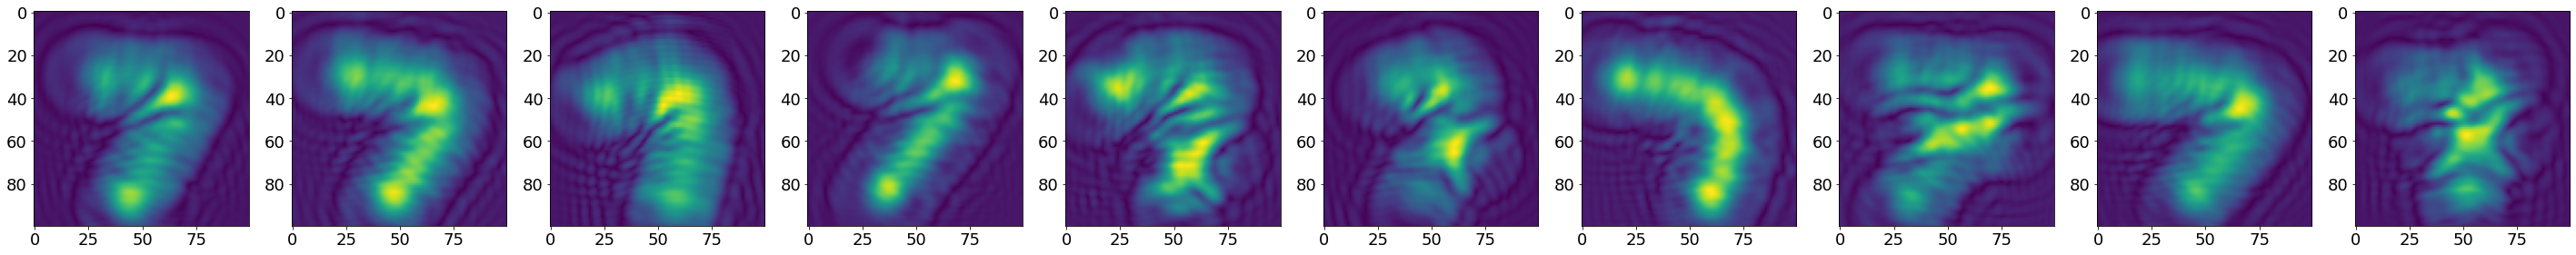

In [241]:
fig, axes = plt.subplots(1, pred.shape[0], figsize=(5*pred.shape[0], 5))
for i, ax in enumerate(axes):
    ax.imshow(pred[i,:,:])

In [144]:
phase = np.loadtxt('data/phase/100px/train_5.csv')
phase = phase * 45 * np.pi / 180
model.layers[3].set_weights([phase])

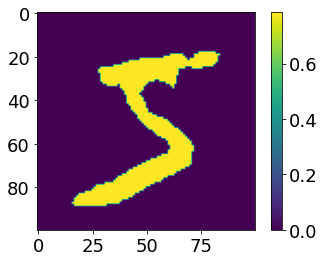

In [145]:
plt.imshow(model.layers[3].get_weights()[0])
plt.colorbar()

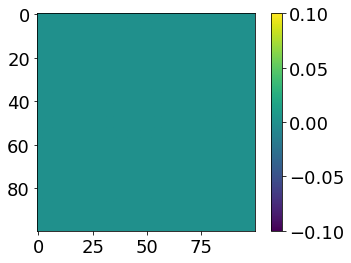

In [148]:
ones = np.ones([1, 28, 28])
pred = model.predict(ones)
plt.imshow(pred[0,:,:])
plt.colorbar()

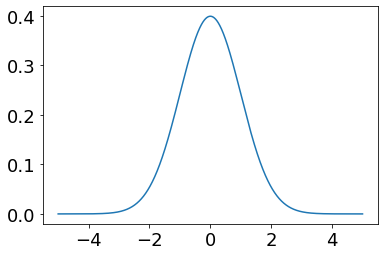

In [203]:
x = np.linspace(-5, 5, 4000)
sig = 1

fx = 1 / (np.sqrt(2*np.pi*sig**2)) * np.exp(-x**2/(2*sig**2))
plt.plot(x, fx)

/Users/takumi/miniforge3/envs/tensorflow25/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


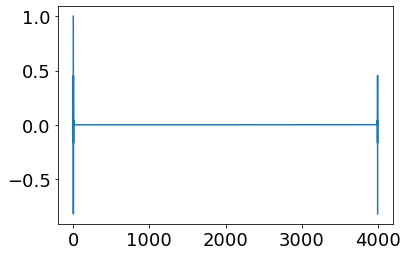

In [217]:
fk = tf.signal.fft(fx) / 400
plt.plot(fk)

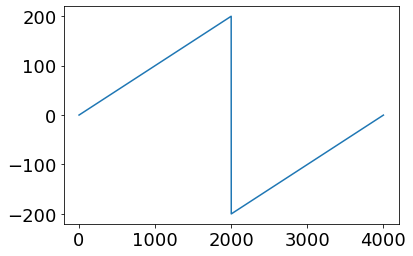

In [218]:
freq = np.fft.fftfreq(4000, d=10/4000)
plt.plot(freq)

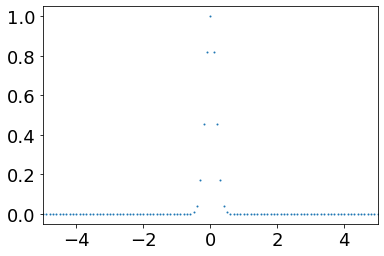

In [219]:
plt.xlim([-5, 5])
plt.scatter(freq, tf.abs(fk), s=1)

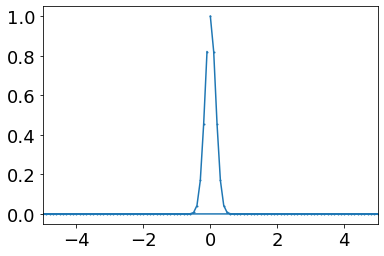

In [225]:
plt.xlim([-5,5])
plt.scatter(freq, tf.abs(fk),s=1)
theory = np.exp(-(2*np.pi*freq)**2 * sig**2 / 2)
plt.plot(freq, theory)